# Modelo para prever qual o proximo resultado para jogos virtuais na BETFAIR

In [0]:
import pandas as pd

In [0]:
df = pd.read_csv('futebol_clubes_20_jogos_anteriores.csv')
d2 = pd.read_csv('futebol_clubes_20_jogos_anteriores.csv')
pd.options.display.max_rows = 100

In [0]:
# df.set_index('datetime', inplace=True)

In [64]:
df.tail()

,goal_back,goal_home,over 2.5,score,team_back,team_home
datetime,,,,,,
2020-04-28 17:50,NaN,NaN,NaN,1 - 0,Manchester Reds,Watford Hornets
2020-04-28 17:53,NaN,NaN,NaN,1 - 0,Dynamo Whites,Manchester Reds
2020-04-28 17:56,NaN,NaN,NaN,2 - 0,Belgium Buffalos,Kazakh Stripes
2020-04-28 18:02,NaN,NaN,NaN,1 - 0,Milan Reds,Turin
2020-04-28 18:05,NaN,NaN,NaN,1 - 1,Islington Reds,Olympique Juniors


### para cada resultado, adicionar em colunas os 20 resultados anteriores a aquele evento

In [0]:
df.drop(['team_back', 'team_home', 'over 2.5', 'goal_back', 'goal_home'], axis=1, inplace=True)

### Transformar os valores em float

In [0]:
for row, content in df.T.iteritems():
  df.loc[row, 'score'] = content['score'].replace(' - ', '.')
  df.loc[row, 'float_score'] = float(content['score'])

In [0]:
df.drop(['score'], axis=1, inplace=True)

### Separa a sobra do DF pra nao dar erro na hora de pegar os resultados dos jogos anteriores

In [0]:
teste_sobra = df.iloc[46000:, :]
df = df.iloc[:46000, :]

In [0]:
# df_bkp = df.copy()
df = df_bkp.copy()

# Para cada resultado ira pegar seus 20 resultados anteriores

In [137]:
df.head()

,float_score
datetime,
2020-01-21 00:02:00,1.2
2020-01-21 00:05:00,0.1
2020-01-21 00:08:00,1.1
2020-01-21 00:11:00,1.0
2020-01-21 00:26:00,0.1


In [0]:
for row, content in df.T.iteritems():
  if row <=20:
    pass
  else:
    for before in range(1,20):
      df.loc[row, str(before)] = df.loc[row-before, 'float_score']
  if row % 1000 == 0:
    print('{} rows processed'.format(row))

In [0]:
df.drop(['index'], axis=1, inplace=True)

In [0]:
df.reset_index(drop=True, inplace=True)

In [0]:
df.to_csv('futebol_clubes_20_jogos_anteriores.csv', index=None)

### Cada linha esta com um evento e seus 20 resultados anteriores

# Adicionar uma coluna com o resultado do jogo futuro, que sera o que iremos prever

In [0]:
df = df.loc[21:, :]

In [0]:
for row, content in df.T.iteritems():
  if row == 0:
    pass
  else:
    df.loc[row, 'future_result'] = df.loc[row+1, 'float_score']
    
    if row % 1000 == 0:
      print('{} rows processed'.format(row))

In [0]:
df.tail(100)

In [0]:
# sns.pairplot(df);

In [0]:
# Transformar a coluna datetime

In [0]:
X_cat = df[['datetime']]

In [0]:
from sklearn.preprocessing import OneHotEncoder
onehotencoder = OneHotEncoder()
X_cat = onehotencoder.fit_transform(X_cat).toarray()

In [0]:
X_cat = pd.DataFrame(X_cat)

In [0]:
# df.drop(0, axis=0, inplace=True)
# X_cat.head()

# Criacao do Modelo

In [14]:
%tensorflow_version 2.x
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
tf.__version__

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


'2.2.0-rc3'

In [0]:
X_numerical = df.copy()

In [0]:
X_numerical.drop(['datetime'], axis=1, inplace=True)

In [0]:
X_all = X_numerical.copy()

## separa a coluna que sera para fazer previsao do dataframe que sera para treinamento

In [305]:
for row, content in X_all.T.iteritems():
  numbers = str(content['future_result']).split('.')
  soma = int(numbers[0]) + int(numbers[1])
  if soma >2:
    X_all.loc[row, 'future_result'] = 1
  else:
    X_all.loc[row, 'future_result'] = 0

ValueError: ignored

In [0]:
# X_all.head(100)

In [0]:
X = X_all.iloc[:-1, :-1].values #ultima linha esta vazia

In [0]:
y = X_all.iloc[:-1, -1:].values #ultima linha esta vazia

In [313]:
X.shape

(20163, 20)

In [33]:
y.shape

(20163, 1)

Base de teste e treinamento

In [0]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
y = scaler.fit_transform(y)

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.01)

In [40]:
X_test.shape

(4033, 20)

In [0]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units = 100, activation='relu', input_shape=(20,)))
model.add(tf.keras.layers.Dense(units=100, activation='relu'))
model.add(tf.keras.layers.Dense(units=100, activation='relu'))
model.add(tf.keras.layers.Dense(units=1, activation='linear'))

In [230]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 100)               2100      
_________________________________________________________________
dense_9 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_10 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 101       
Total params: 22,401
Trainable params: 22,401
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer='Adam', loss='mean_squared_error')

In [0]:
epochs_hist = model.fit(X_train, y_train, epochs = 500)

Text(0, 0.5, 'Training and validation loss')

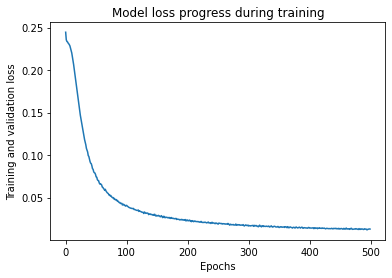

In [318]:
plt.plot(epochs_hist.history['loss'])
# plt.plot(epochs_hist.history['val_loss'])
plt.title('Model loss progress during training')
plt.xlabel('Epochs')
plt.ylabel('Training and validation loss')
# plt.legend(['Training loss', 'Validation loss']);

array([[0.95600003]], dtype=float32)

In [357]:
a = df.iloc[20141,1:-1].to_numpy()
a = np.array([a])
X = np.asarray(a).astype(np.float32)

y_predict = model.predict(X)

if y_predict[0][0] > 0.5:
  print('Proximo sera Over')
else:
  print('Proximo sera Under')

Proximo sera Over


In [345]:
df.loc[20130:, :]

,datetime,float_score,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,future_result
20130,2020-03-03 10:20:00,1.1,0.3,2.0,3.0,1.1,1.0,2.1,0.1,1.0,1.1,1.0,1.0,2.2,2.2,0.2,4.0,0.1,0.0,0.1,1.3,3.0
20131,2020-03-03 10:23:00,3.0,1.1,0.3,2.0,3.0,1.1,1.0,2.1,0.1,1.0,1.1,1.0,1.0,2.2,2.2,0.2,4.0,0.1,0.0,0.1,1.0
20132,2020-03-03 10:26:00,1.0,3.0,1.1,0.3,2.0,3.0,1.1,1.0,2.1,0.1,1.0,1.1,1.0,1.0,2.2,2.2,0.2,4.0,0.1,0.0,2.1
20133,2020-03-03 10:29:00,2.1,1.0,3.0,1.1,0.3,2.0,3.0,1.1,1.0,2.1,0.1,1.0,1.1,1.0,1.0,2.2,2.2,0.2,4.0,0.1,0.1
20134,2020-03-03 10:32:00,0.1,2.1,1.0,3.0,1.1,0.3,2.0,3.0,1.1,1.0,2.1,0.1,1.0,1.1,1.0,1.0,2.2,2.2,0.2,4.0,1.3
20135,2020-03-03 10:35:00,1.3,0.1,2.1,1.0,3.0,1.1,0.3,2.0,3.0,1.1,1.0,2.1,0.1,1.0,1.1,1.0,1.0,2.2,2.2,0.2,1.2
20136,2020-03-03 10:38:00,1.2,1.3,0.1,2.1,1.0,3.0,1.1,0.3,2.0,3.0,1.1,1.0,2.1,0.1,1.0,1.1,1.0,1.0,2.2,2.2,1.2
20137,2020-03-03 10:41:00,1.2,1.2,1.3,0.1,2.1,1.0,3.0,1.1,0.3,2.0,3.0,1.1,1.0,2.1,0.1,1.0,1.1,1.0,1.0,2.2,3.0
20138,2020-03-03 10:44:00,3.0,1.2,1.2,1.3,0.1,2.1,1.0,3.0,1.1,0.3,2.0,3.0,1.1,1.0,2.1,0.1,1.0,1.1,1.0,1.0,3.0
20139,2020-03-03 10:47:00,3.0,3.0,1.2,1.2,1.3,0.1,2.1,1.0,3.0,1.1,0.3,2.0,3.0,1.1,1.0,2.1,0.1,1.0,1.1,1.0,2.0
